CAN BUS SECURITY ANALYSIS - SYSTEM INTEGRATION VERSION

Loading CAN bus datasets...

📊 Dataset Overview:
Speed Attack: (11306, 3)
RPM Attack: (816, 3)
Normal: (707, 3)

=== SPEED ATTACK DATASET ===
   Speed    RPM  Attack
0    0.0  626.0       0
1    0.0  624.0       0
2    0.0  624.0       0
3    0.0  626.0       0
4    0.0  626.0       0

=== RPM ATTACK DATASET ===
      Speed    RPM  Attack
0  5.312724  740.0       0
1  5.312724  742.0       0
2  5.312724  744.0       0
3  5.343792  744.0       0
4  5.343792  742.0       0

=== NORMAL DATASET ===
   Speed    RPM  Attack
0    0.0  636.0       0
1    0.0  640.0       0
2    0.0  640.0       0
3    0.0  638.0       0
4    0.0  638.0       0


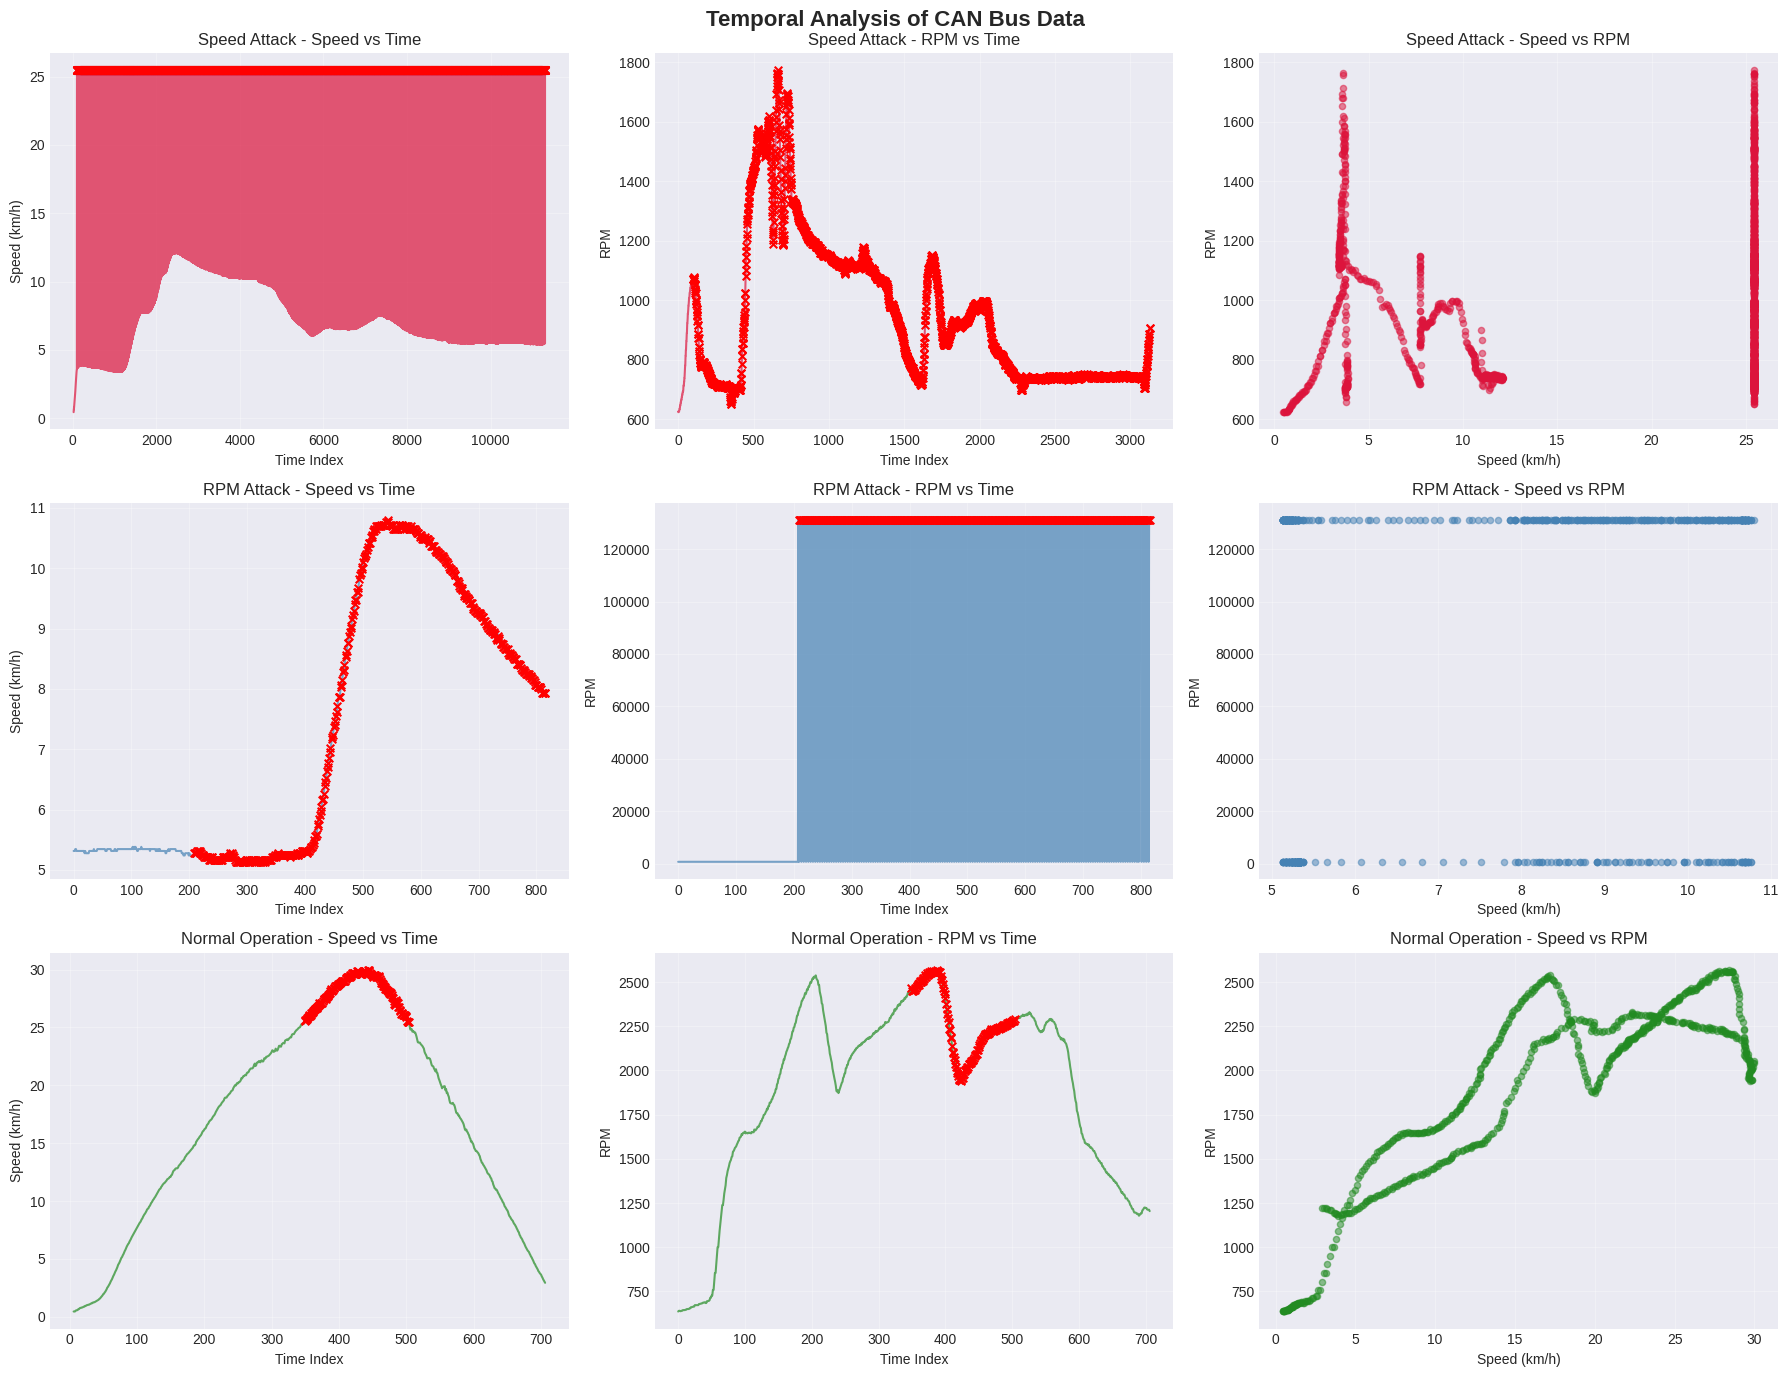

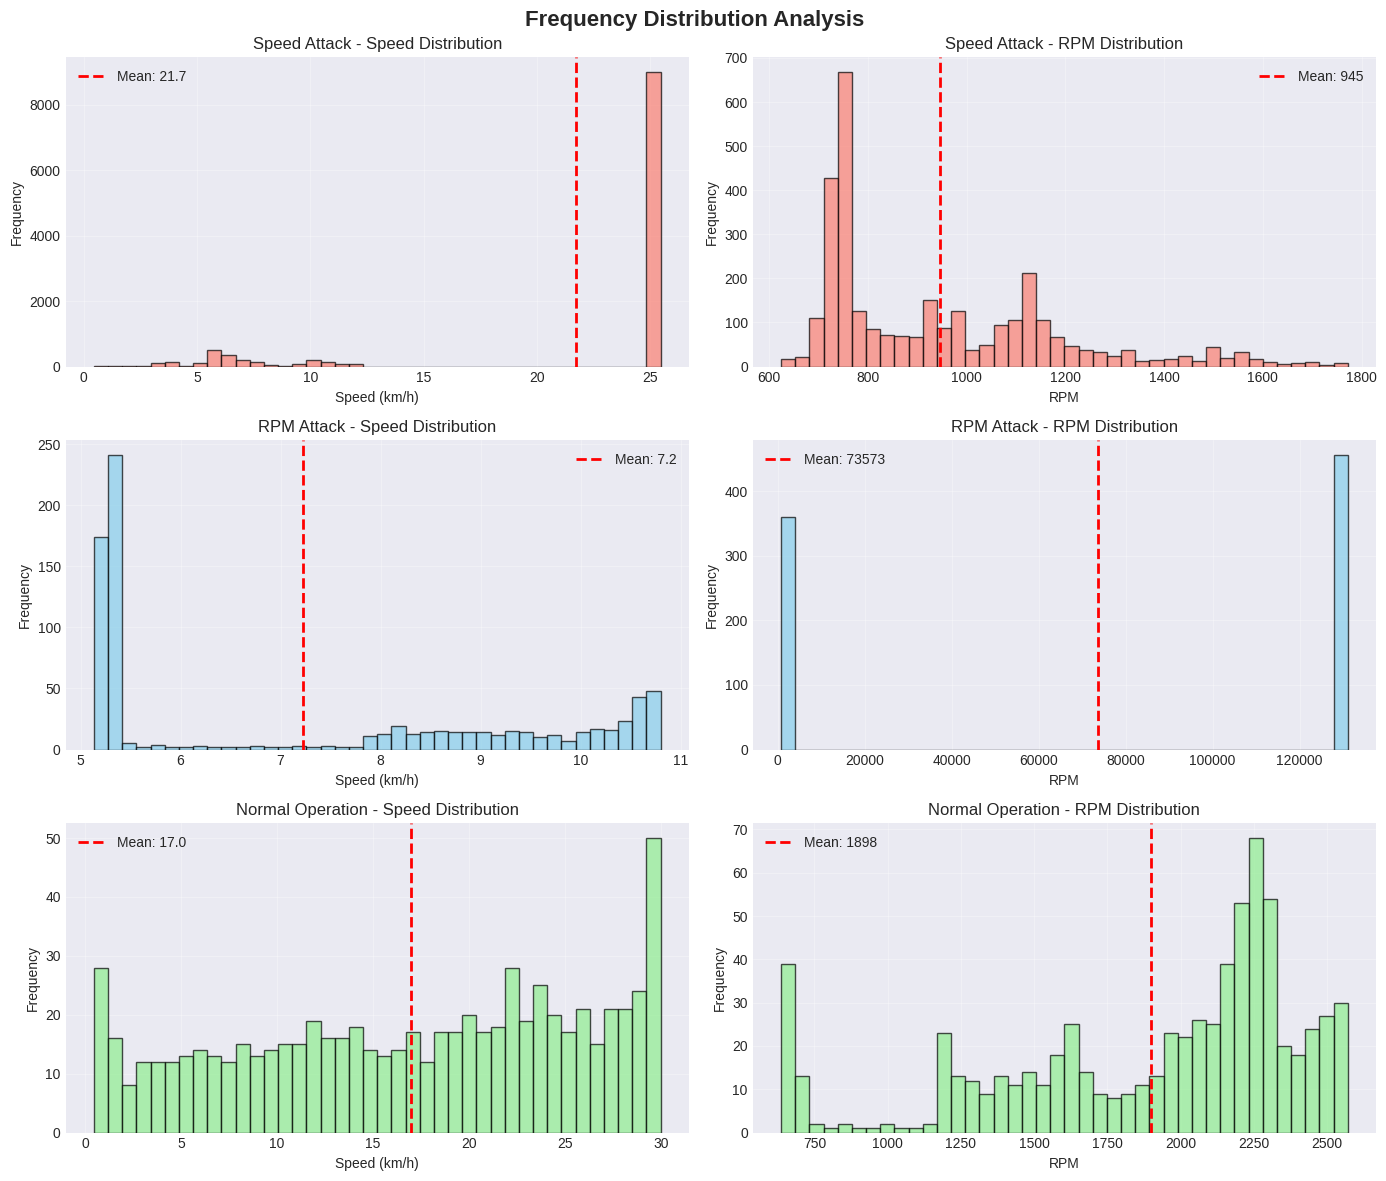


PEARSON CORRELATION ANALYSIS RESULTS

Speed Attack:
  Correlation: -0.008159
  P-Value: 6.48e-01
  Sample Size: 3129

RPM Attack:
  Correlation: 0.334291
  P-Value: 9.37e-23
  Sample Size: 816

Normal Operation:
  Correlation: 0.860268
  P-Value: 1.10e-206
  Sample Size: 701

CORRELATION SUMMARY TABLE
        Scenario  Correlation       P-Value  Sample_Size
    Speed Attack    -0.008159  6.482316e-01         3129
      RPM Attack     0.334291  9.374616e-23          816
Normal Operation     0.860268 1.103138e-206          701


In [ ]:
# =============================================================================
# AUTOMOTIVE CAN BUS SECURITY ANALYSIS SYSTEM
# Version: SI (System Integration)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# System configuration
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Visual configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 60)
print("CAN BUS SECURITY ANALYSIS - SYSTEM INTEGRATION VERSION")
print("=" * 60)

# =============================================================================
# TASK 1: DATA PREPARATION MODULE
# =============================================================================

def read_can_log_SI(filepath_SI):
    """
    Parse CAN bus log files for security analysis
    """
    records_SI = []
    speed_id_SI = '254'
    rpm_id_SI = '115'

    with open(filepath_SI, 'r', encoding='utf-8') as file_SI:
        lines_SI = file_SI.readlines()

    for idx_SI, line_SI in enumerate(lines_SI):
        try:
            msg_SI = {
                'timestamp_SI': line_SI[1:18].strip(),
                'can_id_SI': line_SI[25:28].strip(),
                'dlc_SI': line_SI[29:33].strip(),
                'data_SI': line_SI[33:41].strip(),
                'value_SI': int(line_SI[41:45], 16),
                'attack_SI': 0
            }

            if msg_SI['can_id_SI'] == speed_id_SI:
                if msg_SI['value_SI'] >= 4095:
                    msg_SI['attack_SI'] = 1
                msg_SI['value_SI'] *= 0.0062137119

            elif msg_SI['can_id_SI'] == rpm_id_SI:
                if msg_SI['value_SI'] >= 65535:
                    msg_SI['attack_SI'] = 1
                msg_SI['value_SI'] *= 2

            records_SI.append(msg_SI)

        except (ValueError, IndexError):
            continue

    return records_SI

def process_data_SI(records_SI):
    """
    Convert CAN records to analysis dataframe
    """
    df_raw_SI = pd.DataFrame(records_SI)

    # Filter relevant messages
    mask_SI = (df_raw_SI['can_id_SI'].isin(['254', '115']))
    df_filtered_SI = df_raw_SI[mask_SI].copy()

    # Create pivot structure
    speed_df_SI = df_filtered_SI[df_filtered_SI['can_id_SI'] == '254'][['value_SI', 'attack_SI']]
    rpm_df_SI = df_filtered_SI[df_filtered_SI['can_id_SI'] == '115'][['value_SI', 'attack_SI']]

    # Combine into final structure
    result_SI = pd.DataFrame()
    result_SI['Speed'] = speed_df_SI['value_SI'].reset_index(drop=True)
    result_SI['RPM'] = rpm_df_SI['value_SI'].reset_index(drop=True)

    # Handle attack column
    attack_vals_SI = pd.concat([
        speed_df_SI['attack_SI'].reset_index(drop=True),
        rpm_df_SI['attack_SI'].reset_index(drop=True)
    ])
    result_SI['Attack'] = attack_vals_SI.groupby(attack_vals_SI.index).max()

    # Fill NaN values
    result_SI = result_SI.fillna(0)

    return result_SI

# Load datasets
print("\nLoading CAN bus datasets...")

# Dataset 1: Speed attack
data_speed_SI = read_can_log_SI("CAN Bus log - injection of FFF as the speed reading.log")
df_speed_attack_SI = process_data_SI(data_speed_SI)

# Dataset 2: RPM attack
data_rpm_SI = read_can_log_SI("CAN Bus log - injection of RPM readings.log")
df_rpm_attack_SI = process_data_SI(data_rpm_SI)

# Dataset 3: Normal
data_normal_SI = read_can_log_SI("CAN bus log - no injection of messages.log")
df_normal_SI = process_data_SI(data_normal_SI)

print("\n📊 Dataset Overview:")
print(f"Speed Attack: {df_speed_attack_SI.shape}")
print(f"RPM Attack: {df_rpm_attack_SI.shape}")
print(f"Normal: {df_normal_SI.shape}")

# Display samples
print("\n=== SPEED ATTACK DATASET ===")
print(df_speed_attack_SI.head())
print("\n=== RPM ATTACK DATASET ===")
print(df_rpm_attack_SI.head())
print("\n=== NORMAL DATASET ===")
print(df_normal_SI.head())

# =============================================================================
# TASK 2.1: TEMPORAL ANALYSIS
# =============================================================================

def plot_temporal_SI(datasets_SI, titles_SI):
    """
    Generate temporal analysis plots
    """
    fig_SI, axes_SI = plt.subplots(3, 3, figsize=(18, 14))
    fig_SI.suptitle('Temporal Analysis of CAN Bus Data', fontsize=16, weight='bold')

    colors_SI = ['crimson', 'steelblue', 'forestgreen']

    for i_SI, (data_SI, title_SI, color_SI) in enumerate(zip(datasets_SI, titles_SI, colors_SI)):
        # Extract valid data
        speed_valid_SI = pd.to_numeric(data_SI['Speed'], errors='coerce')
        rpm_valid_SI = pd.to_numeric(data_SI['RPM'], errors='coerce')

        # Speed over time
        ax1_SI = axes_SI[i_SI, 0]
        speed_mask_SI = speed_valid_SI > 0
        if speed_mask_SI.any():
            ax1_SI.plot(np.where(speed_mask_SI)[0],
                       speed_valid_SI[speed_mask_SI],
                       color=color_SI, alpha=0.7, linewidth=1.5)

            # Mark attacks
            attack_mask_SI = (speed_mask_SI) & (data_SI['Attack'] == 1)
            if attack_mask_SI.any():
                ax1_SI.scatter(np.where(attack_mask_SI)[0],
                             speed_valid_SI[attack_mask_SI],
                             color='red', s=30, marker='x', zorder=5)

        ax1_SI.set_title(f'{title_SI} - Speed vs Time')
        ax1_SI.set_xlabel('Time Index')
        ax1_SI.set_ylabel('Speed (km/h)')
        ax1_SI.grid(True, alpha=0.3)

        # RPM over time
        ax2_SI = axes_SI[i_SI, 1]
        rpm_mask_SI = rpm_valid_SI > 0
        if rpm_mask_SI.any():
            ax2_SI.plot(np.where(rpm_mask_SI)[0],
                       rpm_valid_SI[rpm_mask_SI],
                       color=color_SI, alpha=0.7, linewidth=1.5)

            # Mark attacks
            attack_mask_rpm_SI = (rpm_mask_SI) & (data_SI['Attack'] == 1)
            if attack_mask_rpm_SI.any():
                ax2_SI.scatter(np.where(attack_mask_rpm_SI)[0],
                             rpm_valid_SI[attack_mask_rpm_SI],
                             color='red', s=30, marker='x', zorder=5)

        ax2_SI.set_title(f'{title_SI} - RPM vs Time')
        ax2_SI.set_xlabel('Time Index')
        ax2_SI.set_ylabel('RPM')
        ax2_SI.grid(True, alpha=0.3)

        # Speed vs RPM scatter
        ax3_SI = axes_SI[i_SI, 2]
        if speed_mask_SI.any() and rpm_mask_SI.any():
            # Sample equal lengths
            min_len_SI = min(speed_mask_SI.sum(), rpm_mask_SI.sum())
            speed_sample_SI = speed_valid_SI[speed_mask_SI].iloc[:min_len_SI]
            rpm_sample_SI = rpm_valid_SI[rpm_mask_SI].iloc[:min_len_SI]

            ax3_SI.scatter(speed_sample_SI, rpm_sample_SI,
                          color=color_SI, alpha=0.5, s=20)

        ax3_SI.set_title(f'{title_SI} - Speed vs RPM')
        ax3_SI.set_xlabel('Speed (km/h)')
        ax3_SI.set_ylabel('RPM')
        ax3_SI.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate temporal plots
datasets_list_SI = [df_speed_attack_SI, df_rpm_attack_SI, df_normal_SI]
titles_list_SI = ['Speed Attack', 'RPM Attack', 'Normal Operation']
plot_temporal_SI(datasets_list_SI, titles_list_SI)

# =============================================================================
# TASK 2.2: FREQUENCY DISTRIBUTION
# =============================================================================

def plot_frequency_SI(datasets_SI, titles_SI):
    """
    Generate frequency distribution plots
    """
    fig_SI, axes_SI = plt.subplots(3, 2, figsize=(14, 12))
    fig_SI.suptitle('Frequency Distribution Analysis', fontsize=16, weight='bold')

    colors_SI = ['salmon', 'skyblue', 'lightgreen']

    for i_SI, (data_SI, title_SI, color_SI) in enumerate(zip(datasets_SI, titles_SI, colors_SI)):
        # Extract valid data
        speed_valid_SI = pd.to_numeric(data_SI['Speed'], errors='coerce')
        rpm_valid_SI = pd.to_numeric(data_SI['RPM'], errors='coerce')

        # Speed frequency
        ax1_SI = axes_SI[i_SI, 0]
        speed_clean_SI = speed_valid_SI[speed_valid_SI > 0].dropna()
        if len(speed_clean_SI) > 0:
            ax1_SI.hist(speed_clean_SI, bins=40, color=color_SI,
                       edgecolor='black', alpha=0.7)
            ax1_SI.axvline(speed_clean_SI.mean(), color='red',
                          linestyle='--', linewidth=2, label=f'Mean: {speed_clean_SI.mean():.1f}')
            ax1_SI.legend()

        ax1_SI.set_title(f'{title_SI} - Speed Distribution')
        ax1_SI.set_xlabel('Speed (km/h)')
        ax1_SI.set_ylabel('Frequency')
        ax1_SI.grid(True, alpha=0.3)

        # RPM frequency
        ax2_SI = axes_SI[i_SI, 1]
        rpm_clean_SI = rpm_valid_SI[rpm_valid_SI > 0].dropna()
        if len(rpm_clean_SI) > 0:
            ax2_SI.hist(rpm_clean_SI, bins=40, color=color_SI,
                       edgecolor='black', alpha=0.7)
            ax2_SI.axvline(rpm_clean_SI.mean(), color='red',
                          linestyle='--', linewidth=2, label=f'Mean: {rpm_clean_SI.mean():.0f}')
            ax2_SI.legend()

        ax2_SI.set_title(f'{title_SI} - RPM Distribution')
        ax2_SI.set_xlabel('RPM')
        ax2_SI.set_ylabel('Frequency')
        ax2_SI.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate frequency plots
plot_frequency_SI(datasets_list_SI, titles_list_SI)

# =============================================================================
# TASK 2.3: CORRELATION ANALYSIS
# =============================================================================

def calculate_correlation_SI(datasets_SI, titles_SI):
    """
    Perform Pearson correlation analysis
    """
    results_SI = []

    print("\n" + "="*60)
    print("PEARSON CORRELATION ANALYSIS RESULTS")
    print("="*60)

    for data_SI, title_SI in zip(datasets_SI, titles_SI):
        # Extract valid data
        speed_valid_SI = pd.to_numeric(data_SI['Speed'], errors='coerce')
        rpm_valid_SI = pd.to_numeric(data_SI['RPM'], errors='coerce')

        # Get clean data
        speed_clean_SI = speed_valid_SI[speed_valid_SI > 0].dropna()
        rpm_clean_SI = rpm_valid_SI[rpm_valid_SI > 0].dropna()

        # Align lengths
        min_len_SI = min(len(speed_clean_SI), len(rpm_clean_SI))

        if min_len_SI > 2:
            speed_aligned_SI = speed_clean_SI.iloc[:min_len_SI].values
            rpm_aligned_SI = rpm_clean_SI.iloc[:min_len_SI].values

            # Calculate correlation
            corr_SI, pval_SI = stats.pearsonr(speed_aligned_SI, rpm_aligned_SI)

            results_SI.append({
                'Scenario': title_SI,
                'Correlation': corr_SI,
                'P-Value': pval_SI,
                'Sample_Size': min_len_SI
            })

            print(f"\n{title_SI}:")
            print(f"  Correlation: {corr_SI:.6f}")
            print(f"  P-Value: {pval_SI:.2e}")
            print(f"  Sample Size: {min_len_SI}")

    return pd.DataFrame(results_SI)

# Calculate correlations
correlation_df_SI = calculate_correlation_SI(datasets_list_SI, titles_list_SI)
print("\n" + "="*60)
print("CORRELATION SUMMARY TABLE")
print("="*60)
print(correlation_df_SI.to_string(index=False))